In [2]:
%matplotlib inline

# Datasets & DataLoaders

===================




Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
(处理数据样本的代码可能会变得混乱且难以维护;理想情况下,我们需要我们的数据集代码
与我们的模型训练代码解耦,以获得更好的可读性和模块化.)
PyTorch提供了两个数据原语: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset`` ,这俩个允许你使用预加载的数据集和你自己的数据.

``Dataset`` 存储样本和它们对应的标签, 并且 ``DataLoader`` 包装了一个可迭代对象围绕 ``Dataset`` 以方便访问样本.

PyTorch域库提供了许多预加载的数据集 (比如说 FashionMNIST) 子类化了 ``torch.utils.data.Dataset`` and implement functions specific to the particular data.(实现特定于特定数据的函数.)

它们可以用来建立模型的原型和基准. 
You can find them here: 
- `Image Datasets <https://pytorch.org/vision/stable/datasets.html>`_
- `Text Datasets  <https://pytorch.org/text/stable/datasets.html>`_
- `Audio Datasets <https://pytorch.org/audio/stable/datasets.html>`_




## Loading a Dataset
-------------------

Here is an example of how to load the `Fashion-MNIST <https://research.zalando.com/project/fashion_mnist/fashion_mnist/>`_ dataset from TorchVision.

Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples.

Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.
(每个示例包括28×28灰度图像和来自10个类中的一个的关联标签.)

We load the `FashionMNIST Dataset <https://pytorch.org/vision/stable/datasets.html#fashion-mnist>`_ with the following parameters:
 - ``root`` is the path where the train/test data is stored,(是训练/测试数据存放的地址)
 - ``train`` specifies training or test dataset,(代表这是训练数据集还是测试数据集)
 - ``download=True`` downloads the data from the internet if it's not available at ``root``.
 - ``transform`` and ``target_transform`` specify the feature and label transformations(指定特性和标签转换)



In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

/home/zhou/workspace/python/ENV/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Iterating and Visualizing the Dataset(迭代和可视化数据集)
-----------------

We can index ``Datasets`` manually like a list: ``training_data[index]``. 
We use ``matplotlib`` to visualize some samples in our training data.



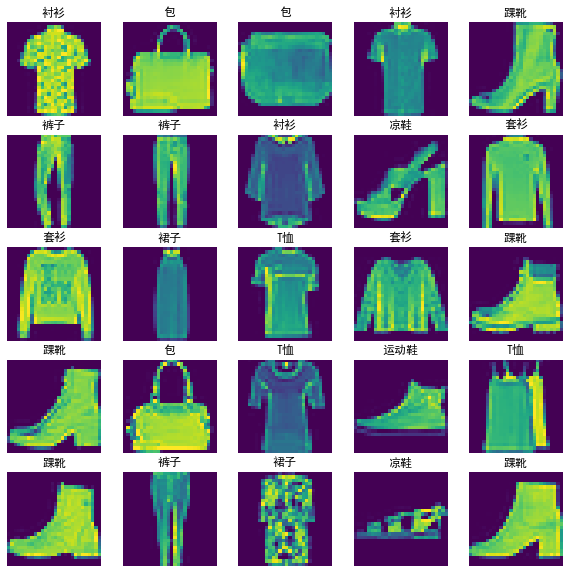

In [4]:
labels_map = {
    0: "T恤",
    1: "裤子",
    2: "套衫",
    3: "裙子",
    4: "外套",
    5: "凉鞋",
    6: "衬衫",
    7: "运动鞋",
    8: "包",
    9: "踝靴",
}

figure = plt.figure(figsize=(10, 10))  # Create a new figure, or activate an existing figure. ( -> figsize -- Width, height in inches.)
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)  # Add an Axes to the figure as part of a subplot arrangement.
    plt.title(labels_map[label])
    plt.axis("off") # 将图片中的轴以及坐标都关掉
    plt.imshow(img.squeeze()) #, cmap="Blues"可以加一个参数调整输出图片的颜色
    # torch.squeeze()函数作用：torch.squeeze() 这个函数主要对数据的维度进行压缩，去掉维数为1的的维度，比如是一行或者一列这种，一个一行三列（1,3）的数去掉第一个维数为一的维度之后就变成（3）行。squeeze(a)就是将a中所有为1的维度删掉。
    # torch.unsqueeze()这个函数主要是对数据维度进行扩充。给指定位置加上维数为一的维度，比如原本有个三行的数据（3），在0的位置加了一维就变成一行三列（1,3）。a.squeeze(N) 就是在a中指定位置N加上一个维数为1的维度。还有一种形式就是b=torch.squeeze(a，N) a就是在a中指定位置N加上一个维数为1的维度
plt.show()

**torch.squeeze(input, dim=None, \*, out=None) → Tensor**

- Returns a tensor with all the dimensions of input of size 1 removed.

    - For example, if input is of shape: $(A \times 1 \times B \times C \times 1 \times D)$ then the out tensor will be of shape: $(A \times B \times C \times D)$.

    - When dim is given, a squeeze operation is done only in the given dimension. If input is of shape: $(A \times 1 \times B)$, squeeze(input, 0) leaves the tensor unchanged, but squeeze(input, 1) will squeeze the tensor to the shape $(A \times B)$.

--------------




## Creating a Custom Dataset for your files(为文件创建自定义数据集)
---------------------------------------------------

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`. 
Take a look at this implementation; the FashionMNIST images are stored 
in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``. 

In the next sections, we'll break down what's happening in each of these functions.



In [5]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

__init__(初始化函数)


The __init__ function is run once when instantiating the Dataset object. We initialize
the directory containing the images, the annotations file, and both transforms (covered 
in more detail in the next section). [当实例化Dataset对象的时候__init__函数只会运行一次.我们初始化包含图像,注释文件和两个转换的目录.]

The labels.csv file looks like: ::

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [6]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

__len__(长度函数)


The __len__ function returns the number of samples in our dataset.
(长度函数返回在我们的dataset中的samples的数量)
Example:



In [7]:
def __len__(self):
    return len(self.img_labels)

__getitem__(获得item的函数)


The __getitem__ function loads and returns a sample from the dataset at the given index ``idx``. 
Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the 
corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the 
tensor image and corresponding label in a tuple.



In [8]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




## Preparing your data for training with DataLoaders(利用DataLoaders来准备用来训练的数据)
-------------------------------------------------
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. 
While training a model, we typically want to 
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to
speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.
(“数据集”一次检索一个样本的数据集功能和标签.

在培训模型时，我们通常希望在“小批量”中传递样本,在每个历元重新排列数据以减少模型过度拟合,并使用Python的“多处理”来加快数据检索.

``DataLoader``是一个iterable，它在一个简单的API中为我们抽象了这种复杂性。)


In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader
--------------------------

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over 
the data loading order, take a look at `Samplers <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`_).

(我们已将该数据集加载到``DataLoader``中,并可以根据需要对该数据集进行迭代.

下面的每次迭代都会返回一批``train_features``和``train_labels``（分别包``batch_size=64``功能和标签）.

因为我们指定了``shuffle=True``,所以在迭代所有批处理之后,数据将被洗牌.
（以便对数据加载顺序进行更细粒度的控制,take a look at `Samplers <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`_）.



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


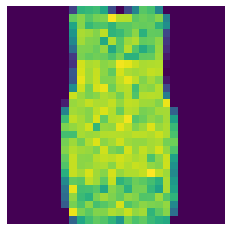

Label: 3,裙子


In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img) # , cmap="gray"
plt.axis("off")
plt.show()
print(f"Label: {label},{labels_map[label.item()]}")

--------------




Further Reading
--------------
- `torch.utils.data API <https://pytorch.org/docs/stable/data.html>`_

